In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import sys, os, pathlib
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

import numpy as np
import pandas as pd
import nibabel as nib
import meshio
import torch
import warp as wp
wp.config.quiet = True

import matplotlib as mpl
import pyvista as pv

sys.path.append('../..')
import project
from project.core.utils import pprint

torch.cuda.is_available()

True

In [3]:
config = project.core.fileio.load_json('2025-11-05_config.json')
config

Loading 2025-11-05_config.json


{'dataset': 'shapenet',
 'data_root': '/ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem',
 'examples': {'unit_policy': 'prefer_metadata',
  'default_unit': 0.01,
  'volume_tag': 'volume_vr',
  'mat_fields_tag': 'mat_fields_vr',
  'sim_fields_tag': 'sim_fields_vr',
  'img_fields_tag': 'img_fields_vr',
  'material_tag': 'material_vr',
  'image_tag': 'solid_texture_vr'},
 'preprocess': {'preprocess_binary_mask': {'pad_factor': 0.37},
  'preprocess_surface_mesh': {},
  'create_mesh_region_mask': {},
  'create_volume_mesh_from_mask': {'use_affine_spacing': False,
   'pygalmesh_kws': {'max_facet_distance': 0.75,
    'max_cell_circumradius': 5.0,
    'lloyd': True,
    'odt': True}},
  'create_material_mask': {'sample_kws': {'vote_rate': 0.0001}},
  'create_mesh_fields': {},
  'simulate_displacement_field': {'nu_value': 0.4,
   'scalar_degree': 0,
   'vector_degree': 1,
   'solver_kws': {}},
  'generate_volumetric_image': {'annot_path': '/ocean/projects/asc170022p/mtragoza/lu

In [4]:
%autoreload
ds = project.datasets.shapenet.ShapeNetDataset(data_root='../../data/ShapeNetSem')
ds.load_metadata()

# wss.1f5c74f0a55cbf9798d5fc0473d00a1c - nan with 1e-5 reg weight

ex = next(ds.examples(
    subjects=['wss.1e5abf0465d97d826118a17db9de8c0'],
    variant='2025-11-02',
    **config['examples']
))
pprint(ex, 3)

Example()
├── dataset:  'ShapeNet'
├── subject:  'wss.1e5abf0465d97d826118a17db9de8c0'
├── variant:  '2025-11-02'
├── paths:    dict(len=14)
|   ├── 'source_mesh':   PosixPath('../../data/ShapeNetSem/models-OBJ/models/1e5abf0465d97d826118a17db9de8c0.obj')
|   ├── 'source_mask':   PosixPath('../../data/ShapeNetSem/models-binvox-solid/1e5abf0465d97d826118a17db9de8c0.binvox')
|   ├── 'surface_mesh':  PosixPath('../../data/ShapeNetSem/2025-11-02/1e5abf0465d97d826118a17db9de8c0/meshes/surface.xdmf')
|   ├── 'binary_mask':   PosixPath('../../data/ShapeNetSem/2025-11-02/1e5abf0465d97d826118a17db9de8c0/masks/binary.nii.gz')
|   ├── 'region_mask':   PosixPath('../../data/ShapeNetSem/2025-11-02/1e5abf0465d97d826118a17db9de8c0/masks/regions.nii.gz')
|   ├── 'volume_mesh':   PosixPath('../../data/ShapeNetSem/2025-11-02/1e5abf0465d97d826118a17db9de8c0/meshes/volume_vr.xdmf')
|   ├── 'material_mask': PosixPath('../../data/ShapeNetSem/2025-11-02/1e5abf0465d97d826118a17db9de8c0/masks/material_vr.nii.g

Loading ../../data/ShapeNetSem/2025-11-02/1e5abf0465d97d826118a17db9de8c0/meshes/img_fields_vr.xdmf


2025-11-10 13:41:17.736 (   1.783s) [    14C25CC78200]vtkXOpenGLRenderWindow.:1416  WARN| bad X server connection. DISPLAY=


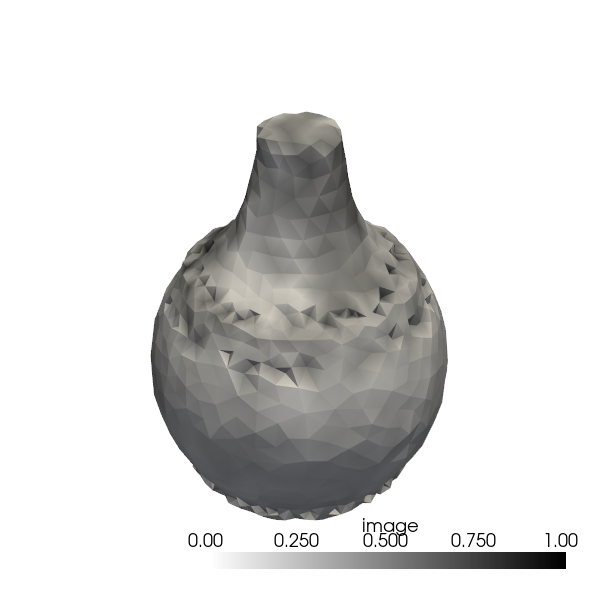

In [5]:
import project.visual.pyvista
mesh = project.core.fileio.load_meshio(ex.paths['img_fields'])
pv_mesh = pv.wrap(mesh)
p = pv.Plotter(window_size=(600,600))
p.add_mesh(pv_mesh, scalars='image', cmap='binary', opacity=1.0, clim=(0,1))
#p.add_mesh(pv_mesh.slice(normal=[1,1,1], origin=pv_mesh.center), scalars='image', cmap='binary', clim=(0,1))
p.show(jupyter_backend='static')

Loading ../../data/ShapeNetSem/2025-11-02/1e5abf0465d97d826118a17db9de8c0/images/solid_texture_vr.nii.gz


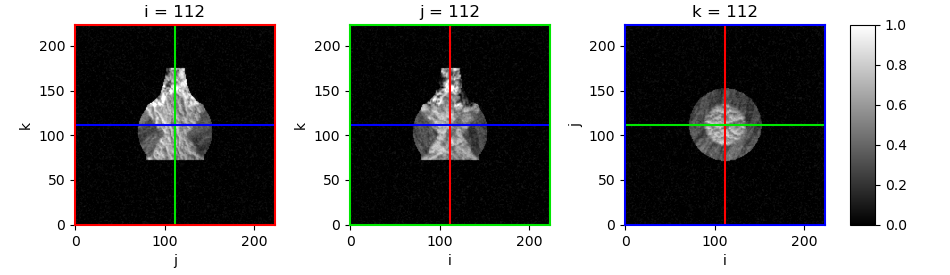

In [6]:
import project.visual.matplotlib
nifti = project.core.fileio.load_nibabel(ex.paths['input_image'])
image = nifti.get_fdata()
_ = project.visual.matplotlib.show_image_slices(image, cmap='gray', clim=(0,1))

In [38]:
%autoreload
import project.optimization
from pathlib import Path
import warp as wp
wp.config.quiet = True

project.preprocessing.api.simulate_displacement_field(
    mesh_path=ex.paths['img_fields'],
    output_path=Path('simulated.xdmf'),
    unit_m=ex.metadata['unit'],
    device='cuda',
    **config['preprocess']['simulate_displacement_field']
)

Loading ../../data/ShapeNetSem/2025-11-02/1e5abf0465d97d826118a17db9de8c0/meshes/img_fields_vr.xdmf
<meshio mesh object>
  Number of points: 3246
  Number of cells:
    tetra: 15150
  Point data: rho, E, u, bc, res, image
  Cell data: medit:ref, region, material, rho, E, image
Simulating displacement using material properties
Assigning simulation fields to mesh
('u', (3246, 3), dtype('float32'), np.float32(-1.6179175))
('bc', (3246, 3), dtype('float32'), np.float32(0.0))
('res', (3246, 3), dtype('float32'), np.float32(-0.0035461944))
Saving simulated.xdmf


In [8]:
mesh = project.core.fileio.load_meshio(ex.paths['img_fields'])
mesh

Loading ../../data/ShapeNetSem/2025-11-02/1e5abf0465d97d826118a17db9de8c0/meshes/img_fields_vr.xdmf


<meshio mesh object>
  Number of points: 3246
  Number of cells:
    tetra: 15150
  Point data: rho, E, u, bc, res, image
  Cell data: medit:ref, region, material, rho, E, image

In [48]:
%autoreload
import project.optimization
from pathlib import Path
import warp as wp
wp.config.quiet = True

metrics = project.optimization.optimize_elasticity_field(
    mesh_path=ex.paths['img_fields'],
    output_path=Path('optimize.xdmf'),
    unit_m=ex.metadata['unit'],
    rho_known=True,
    device='cuda',
    **config['optimize']
)
metrics

Loading ../../data/ShapeNetSem/2025-11-02/1e5abf0465d97d826118a17db9de8c0/meshes/img_fields_vr.xdmf
<meshio mesh object>
  Number of points: 3246
  Number of cells:
    tetra: 15150
  Point data: rho, E, u, bc, res, image
  Cell data: medit:ref, region, material, rho, E, image
Optimizing elasticity using observed displacement
Optimizing global parameter(s)
iter	loss (rel_delta)	grad_norm (rel_init)	param_norm (update_norm)
0	1.5542e+00 (nan)	3.3522e+00 (nan)	3.3522e+00 (nan)
1	4.4146e-02 (9.7159e-01)	3.3522e+00 (1.0000e+00)	3.3522e+00 (2.8449e-07)
Optimization converged
Optimizing local parameter(s)
iter	loss (rel_delta)	grad_norm (rel_init)	param_norm (update_norm)
0	4.4146e-02 (nan)	9.0925e+00 (nan)	9.0925e+00 (nan)
1	7.0472e-05 (9.9840e-01)	1.0051e+01 (1.1054e+00)	1.0051e+01 (3.5251e-01)
2	3.8917e-05 (4.4777e-01)	1.0955e+01 (1.2048e+00)	1.0955e+01 (2.8232e-01)
3	2.9520e-05 (2.4145e-01)	1.1676e+01 (1.2841e+00)	1.1676e+01 (2.0660e-01)
4	2.4769e-05 (1.6096e-01)	1.2301e+01 (1.3529e+00)	

{'res.norm': 0.013430563102070563,
 'res.rms': 0.024423871097018286,
 'u.norm': 4.885703337979579,
 'u.rms': 7.9295374879602285,
 'u.rmse': 0.04671644203924057,
 'u.nrmse': 0.005889010838290749,
 'u.pcorr': 0.9999802773760347,
 'u.scorr': 0.9949479235061215,
 'E.norm': 2567.404527246989,
 'E.rms': 2736.2727333483194,
 'E.rmse': 658.9338392756109,
 'E.nrmse': 0.23775016113532496,
 'E.pcorr': 0.7312334314099662,
 'E.scorr': 0.4255392115360896}

Loading optimize.xdmf


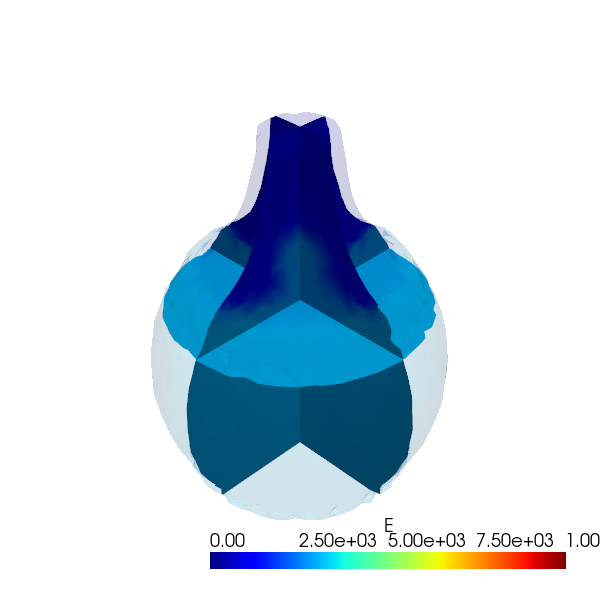

In [49]:
mesh = project.core.fileio.load_meshio('optimize.xdmf')
pv_mesh = pv.wrap(mesh)

size = 600
p = pv.Plotter(window_size=(size,size))
p.add_mesh(pv_mesh, scalars='E', cmap='jet', opacity=0.1, clim=(0,1e4))
p.add_mesh(pv_mesh.slice_orthogonal(), scalars='E', cmap='jet', clim=(0,1e4))
p.show(jupyter_backend='static')

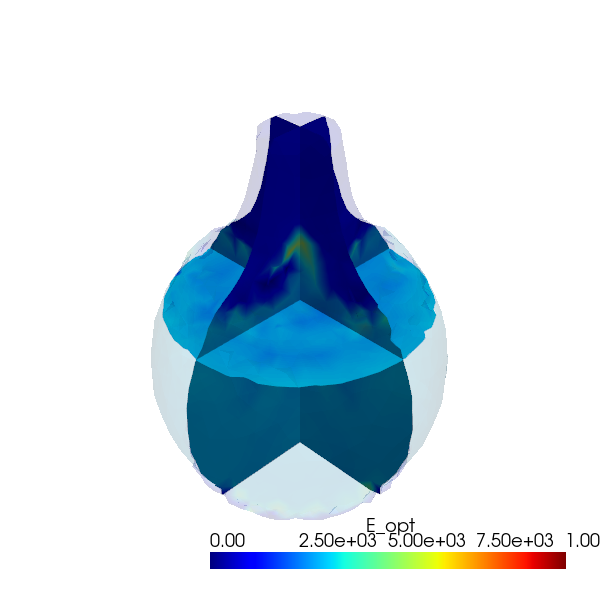

In [50]:
p = pv.Plotter(window_size=(size,size))
p.add_mesh(pv_mesh, scalars='E_opt', cmap='jet', opacity=0.1, clim=(0,1e4))
p.add_mesh(pv_mesh.slice_orthogonal(), scalars='E_opt', cmap='jet', clim=(0,1e4))
p.show(jupyter_backend='static')

In [32]:
%%time
project.preprocessing.api.rasterize_elasticity_field(
    image_path=ex.paths['input_image'],
    mesh_path=Path('optimize.xdmf'),
    output_path=Path('rasterized.nii.gz'),
    unit_m=ex.metadata['unit'],
    nu_value=0.4,
    scalar_degree=1,
    E_key='E_opt'
)

Loading ../../data/ShapeNetSem/2025-11-02/1e5abf0465d97d826118a17db9de8c0/images/solid_texture_vr.nii.gz
Loading optimize.xdmf
Rasterizing elasticity field on voxel grid
Saving rasterized.nii.gz
CPU times: user 30.9 s, sys: 561 ms, total: 31.5 s
Wall time: 31 s


Loading ../../data/ShapeNetSem/2025-11-02/1e5abf0465d97d826118a17db9de8c0/fields/elasticity.nii.gz
Loading rasterized.nii.gz


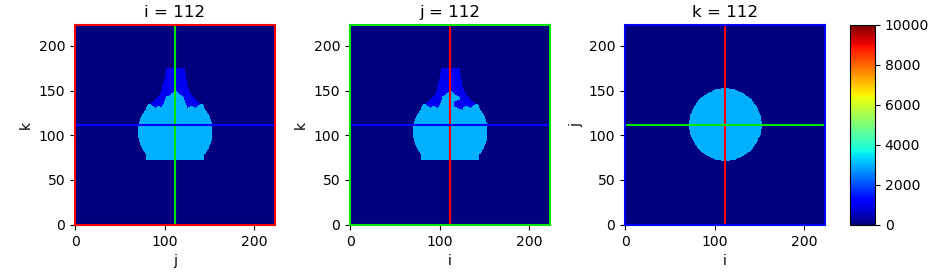

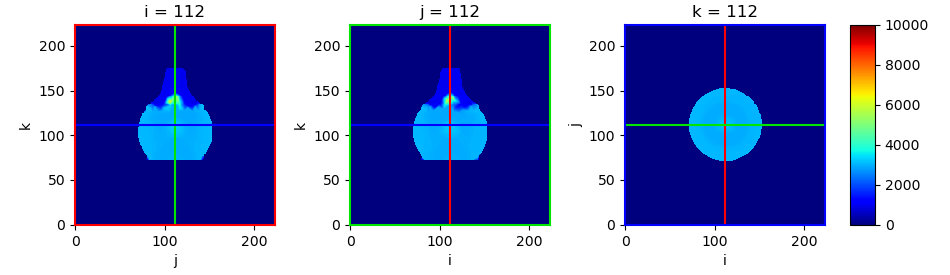

In [33]:
import project.visual.matplotlib
nifti = project.core.fileio.load_nibabel(ex.paths['elastic_field'])
_ = project.visual.matplotlib.show_image_slices(nifti.get_fdata(), cmap='jet', clim=(0, 1e4))

nifti = project.core.fileio.load_nibabel(Path('rasterized.nii.gz'))
_ = project.visual.matplotlib.show_image_slices(nifti.get_fdata()[...,0], cmap='jet', clim=(0, 1e4))

# Inverse optimization development

In [21]:
mesh_path = ex.paths['volume_mesh']
density_path = ex.paths['density_field']
elastic_path = ex.paths['elastic_field']
unit = ex.metadata['unit']
unit

0.0136197560186615

In [22]:
mesh = project.core.fileio.load_meshio(mesh_path)
density_nifti = project.core.fileio.load_nibabel(density_path)
elastic_nifti = project.core.fileio.load_nibabel(elastic_path)

Loading ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/meshes/volume.xdmf
Loading ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/fields/density.nii.gz
Loading ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/fields/elasticity.nii.gz


In [8]:
affine_d = density_nifti.affine
affine_e = elastic_nifti.affine
np.allclose(affine_d, affine_e)

True

In [9]:
rho_field = density_nifti.get_fdata().astype(np.float32)
E_field = elastic_nifti.get_fdata().astype(np.float32)
rho_field.shape == E_field.shape

True

In [11]:
import project.core.transforms
pts_voxel = project.core.transforms.world_to_voxel_coords(mesh.points, affine_d)

In [12]:
tensor_kws = dict(dtype=torch.float32, device='cuda')
pts_tensor = torch.as_tensor(pts_voxel, **tensor_kws)
rho_tensor = torch.as_tensor(rho_field, **tensor_kws).unsqueeze(0)
E_tensor = torch.as_tensor(E_field, **tensor_kws).unsqueeze(0)
pts_tensor.shape, rho_tensor.shape, E_tensor.shape

(torch.Size([6846, 3]),
 torch.Size([1, 224, 224, 224]),
 torch.Size([1, 224, 224, 224]))

In [14]:
import project.core.interpolation
rho_nodes = project.core.interpolation.interpolate_image(rho_tensor, pts_tensor)
E_nodes = project.core.interpolation.interpolate_image(E_tensor, pts_tensor)
print(rho_nodes.mean())
print(E_nodes.mean())
rho_nodes.shape, E_nodes.shape

tensor(394.1529, device='cuda:0')
tensor(2411.2158, device='cuda:0')


(torch.Size([6846, 1]), torch.Size([6846, 1]))

In [15]:
nu_value = 0.4
mu_nodes, lam_nodes = project.core.transforms.compute_lame_parameters(E_nodes, nu_value)
bc_nodes = torch.zeros_like(pts_tensor, **tensor_kws)